In [6]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import scanpy as sc
from scipy import sparse
from scipy.special import softmax

import networkx as nx
import torch

ROOT = Path('../')
sys.path.append(str(ROOT))
import CAME
from CAME import pipeline, pp, pl

In [7]:
from CAME.utils import load_example_data

example_data_dict = load_example_data()
print(example_data_dict.keys())

dsnames = ('Baron_human', 'Baron_mouse')

adatas = example_data_dict['adatas']
dsnames = example_data_dict['dataset_names']
df_varmap = example_data_dict['varmap']
df_varmap_1v1 = example_data_dict['varmap_1v1']

key_class1 = key_class2 = example_data_dict['key_class']

# setting directory for results
time_tag = CAME.make_nowtime_tag()
resdir = ROOT /'_temp' / f'{dsnames}-{time_tag}'
figdir = resdir / 'figs'
CAME.check_dirs(figdir)

dict_keys(['adatas', 'varmap', 'varmap_1v1', 'dataset_names', 'key_class'])
a new directory made:
	../_temp/('Baron_human', 'Baron_mouse')-(07-11 23.54.18)/figs


In [ ]:
# ========= customize paths ==========
datadir = ROOT / 'came/sample_data'
sp1, sp2 = ('human', 'mouse')
dsnames = ('Baron_human', 'Baron_mouse')

df_varmap_1v1 = pd.read_csv(datadir / f'gene_matches_1v1_{sp1}2{sp2}.csv', )
df_varmap = pd.read_csv(datadir / f'gene_matches_{sp1}2{sp2}.csv', )

dsn1, dsn2 = dsnames
adata_raw1 = sc.read_h5ad(datadir / f'raw-{dsn1}.h5ad')
adata_raw2 = sc.read_h5ad(datadir / f'raw-{dsn2}.h5ad')
adatas = [adata_raw1, adata_raw2]

key_class1 = 'cell_ontology_class'
key_class2 = 'cell_ontology_class'

# setting directory for results
time_tag = make_nowtime_tag()
resdir = ROOT /'_temp' / f'{dsnames}-{time_tag}'


In [ ]:
# ====== subsampling and filtering genes (optional) =====

for _adt, _name in zip([adata_raw1, adata_raw2], dsnames):
    if _adt.shape[0] >= 2e4:
        print(f'Doing subsampling for {_name}')
        sc.pp.subsample(_adt, fraction=0.5)

sc.pp.filter_genes(adata_raw1, min_cells=3)
sc.pp.filter_genes(adata_raw2, min_cells=3)

In [8]:
''' default pipeline of CAME
'''
n_epochs = 20
batch_size = 2048

came_inputs, (adata1, adata2) = pipeline.preprocess_unaligned(
    adatas,
    key_class=key_class1,
    use_scnets=True,
)

dpair, trainer, h_dict, predictor, ENV_VARs = pipeline.main_for_unaligned(
    **came_inputs,
    df_varmap=df_varmap,
    df_varmap_1v1=df_varmap_1v1,
    dataset_names=dsnames,
    key_class1=key_class1,
    key_class2=key_class2,
    do_normalize=True,
    n_epochs=n_epochs,
    resdir=resdir,
    n_pass=100,
    params_model=dict(residual=False),
    batch_size=batch_size,
)

obs_ids1, obs_ids2 = dpair.obs_ids1, dpair.obs_ids2
obs = dpair.obs
classes = predictor.classes


A copy of AnnData made!
No copy was made, the input AnnData will be changed!
normalizing datasets with default settings.
performing total-sum normalization, target_sum=None...
using the build-in function `sc.pp.scale(..)`


/Users/xingyan/.conda/envs/dgl/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:845: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


A copy of AnnData made!
No copy was made, the input AnnData will be changed!
normalizing datasets with default settings.
performing total-sum normalization, target_sum=None...
using the build-in function `sc.pp.scale(..)`


/Users/xingyan/.conda/envs/dgl/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:845: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


0    569
1    321
2    279
3    254
4    223
5    133
6     62
7     45
Name: clust_lbs, dtype: int64
[leiden] Time used:  0.1749 s
computing differentially expressed genes using t-test
computing differential expression analysis using default settings,
 (assume that the expressioin values are already normalized)
groups to be removed:
	 []
650 genes before taking unique
taking total of 523 unique differential expressed genes
computing differentially expressed genes using t-test
computing differential expression analysis using default settings,
 (assume that the expressioin values are already normalized)
groups to be removed:
	 []
400 genes before taking unique
taking total of 345 unique differential expressed genes
already exsists:
	../_temp/('Baron_human', 'Baron_mouse')-(07-11 23.54.18)/figs
already exsists:
	../_temp/('Baron_human', 'Baron_mouse')-(07-11 23.54.18)
No copy was made, the input AnnData will be changed!
normalizing datasets with default settings.
performing total-sum nor

 50%|█████     | 1/2 [00:00<00:00,  9.20it/s]

-------------------- Summary of the DGL-Heterograph --------------------
Graph(num_nodes={'cell': 4028, 'gene': 6556},
      num_edges={('cell', 'express', 'gene'): 1513823, ('cell', 'self_loop_cell', 'cell'): 4028, ('cell', 'similar_to', 'cell'): 25908, ('gene', 'expressed_by', 'cell'): 1513823, ('gene', 'homolog_with', 'gene'): 12462},
      metagraph=[('cell', 'gene', 'express'), ('cell', 'cell', 'self_loop_cell'), ('cell', 'cell', 'similar_to'), ('gene', 'cell', 'expressed_by'), ('gene', 'gene', 'homolog_with')])
second-order connection: False
self-loops for observation-nodes: True
self-loops for variable-nodes: True
type B pancreatic cell      1517
pancreatic ductal cell       565
pancreatic A cell            768
pancreatic acinar cell       231
pancreatic PP cell           108
pancreatic D cell            362
pancreatic stellate cell     174
endothelial cell             201
macrophage                    54
mast cell                      8
Schwann cell                   8
T cell  

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 00000 | Train Acc: 0.0439 | Test Acc: 0.0525 (max=0.0525) | AMI=0.0558 | Time: 1.9672


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 00001 | Train Acc: 0.0990 | Test Acc: 0.1559 (max=0.1559) | AMI=0.0106 | Time: 1.9783


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 00002 | Train Acc: 0.2815 | Test Acc: 0.2556 (max=0.2556) | AMI=0.1180 | Time: 1.9445


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 00003 | Train Acc: 0.3375 | Test Acc: 0.2375 (max=0.2556) | AMI=0.0306 | Time: 1.9269


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 00004 | Train Acc: 0.3058 | Test Acc: 0.3706 (max=0.3706) | AMI=0.0099 | Time: 1.9310


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 00005 | Train Acc: 0.3291 | Test Acc: 0.4099 (max=0.4099) | AMI=0.0656 | Time: 1.9245


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 00006 | Train Acc: 0.3819 | Test Acc: 0.4295 (max=0.4295) | AMI=0.1541 | Time: 1.9199


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 00007 | Train Acc: 0.4468 | Test Acc: 0.4178 (max=0.4295) | AMI=0.2568 | Time: 1.9178


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 00008 | Train Acc: 0.5121 | Test Acc: 0.4862 (max=0.4862) | AMI=0.3465 | Time: 1.9091


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 00009 | Train Acc: 0.4991 | Test Acc: 0.4374 (max=0.4862) | AMI=0.3759 | Time: 1.9076


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 00010 | Train Acc: 0.4823 | Test Acc: 0.3340 (max=0.4862) | AMI=0.4058 | Time: 1.9017


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 00011 | Train Acc: 0.4963 | Test Acc: 0.3563 (max=0.4862) | AMI=0.3917 | Time: 1.8972


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 00012 | Train Acc: 0.5476 | Test Acc: 0.3468 (max=0.4862) | AMI=0.4381 | Time: 1.8977


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 00013 | Train Acc: 0.5789 | Test Acc: 0.4236 (max=0.4862) | AMI=0.4546 | Time: 1.8956


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 00014 | Train Acc: 0.6900 | Test Acc: 0.5981 (max=0.5981) | AMI=0.4865 | Time: 1.8925


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 00015 | Train Acc: 0.6587 | Test Acc: 0.6246 (max=0.6246) | AMI=0.5143 | Time: 1.8891


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 00016 | Train Acc: 0.7932 | Test Acc: 0.7312 (max=0.7312) | AMI=0.5507 | Time: 1.8859


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 00017 | Train Acc: 0.7726 | Test Acc: 0.7359 (max=0.7359) | AMI=0.5418 | Time: 1.8833


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 00018 | Train Acc: 0.7969 | Test Acc: 0.7577 (max=0.7577) | AMI=0.5784 | Time: 1.8818


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 00019 | Train Acc: 0.7670 | Test Acc: 0.7423 (max=0.7577) | AMI=0.5888 | Time: 1.8804
figure has been saved into:
	../_temp/('Baron_human', 'Baron_mouse')-(07-11 23.54.18)/figs/cluster_index.png
states loaded from: ../_temp/('Baron_human', 'Baron_mouse')-(07-11 23.54.18)/_models/weights_epoch19.pt
eval_current


100%|██████████| 2/2 [00:00<00:00,  2.38it/s]


type B pancreatic cell      1517
pancreatic ductal cell       565
pancreatic A cell            768
pancreatic acinar cell       231
pancreatic PP cell           108
pancreatic D cell            362
pancreatic stellate cell     174
endothelial cell             201
macrophage                    54
mast cell                      8
Schwann cell                   8
T cell                        11
pancreatic epsilon cell        3
unknown                       18
dtype: int64
object saved into:
	 ../_temp/('Baron_human', 'Baron_mouse')-(07-11 23.54.18)/datapair_init.pickle
figure has been saved into:
	../_temp/('Baron_human', 'Baron_mouse')-(07-11 23.54.18)/figs/confusion_matrix(acc74.2%).png
figure has been saved into:
	../_temp/('Baron_human', 'Baron_mouse')-(07-11 23.54.18)/figs/heatmap_probas.pdf


In [ ]:
''' trainer '''
%matplotlib inline
trainer.plot_class_accs()
trainer.plot_cluster_index()

# trainer.plot_class_accs(fp=figdir / 'clf_acc.pdf')
trainer.plot_class_accs(fp=figdir / 'clf_acc.svg')
trainer.plot_cluster_index(fp=figdir / 'cluster_index_.svg')
# trainer.plot_cluster_index(fp=figdir / 'cluster_index_.svg')

In [ ]:
load_other_ckpt = False
if load_other_ckpt:
    obs, df_probs, h_dict, predictor = pipeline.gather_came_results(
            dpair,
            trainer,
            classes=ENV_VARs['classes'],
            keys=(key_class1, key_class2),
            keys_compare=(key_class1, key_class2),
            resdir=resdir,
            checkpoint='last',
            batch_size=None,
    )

dense normalization
figure has been saved into:
	../_temp/('Baron_human', 'Baron_mouse')-(07-11 23.54.18)/figs/contingency_mat.png


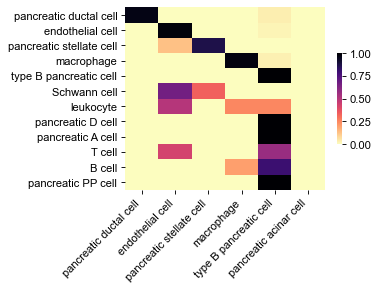

In [20]:
# contingency matrix for query dataset
y_true = obs['celltype'][obs_ids2].values
y_pred = obs['predicted'][obs_ids2].values
ax, contmat = pl.plot_contingency_mat(
    y_true, y_pred, norm_axis=1, 
    order_rows=False, order_cols=False,
)
pl._save_with_adjust(ax.figure, figdir / 'contingency_mat.png')
ax.figure

In [13]:
# ============== heatmap of predicted probabilities ==============
name_label = 'celltype'
cols_anno = ['celltype', 'predicted'][:]
df_probs = obs[list(classes)]

# probas_all = CAME.as_probabilities(
#     trainer.eval_current()['cell'], 
#     mode='sigmoid')
# df_probs = pd.DataFrame(probas_all, columns=classes)


# df_lbs = obs[cols_anno][obs[key_class1] == 'unknown'].sort_values(cols_anno)
df_lbs = obs[cols_anno].iloc[obs_ids2].sort_values(cols_anno)

indices = CAME.subsample_each_group(df_lbs['celltype'], n_out=50, )
# indices = df_lbs.index
df_data = df_probs.loc[indices, :].copy()
df_data = df_data[sorted(df_lbs['predicted'].unique())]  # .T
lbs = df_lbs[name_label][indices]

_ = pl.heatmap_probas(
    df_data.T, lbs, name_label='true label',
    figsize=(5, 3.), fp=figdir / f'heatmap_probas.pdf'
)


figure has been saved into:
	../_temp/('Baron_human', 'Baron_mouse')-(07-11 23.54.18)/figs/confusion_matrix.png
figure has been saved into:
	../_temp/('Baron_human', 'Baron_mouse')-(07-11 23.54.18)/figs/heatmap_probas.pdf


In [ ]:
# In[]
# ============== heatmap of predicted probabilities (loop test) ==============
name_label = 'celltype'
cols_anno = ['celltype', 'predicted'][:]

out_cell = trainer.eval_current()['cell']
probas_all = CAME.as_probabilities(out_cell, mode='sigmoid')
df_probs = pd.DataFrame(probas_all, columns=classes)

for i, _obs_ids in enumerate([obs_ids1, obs_ids2]):
    # df_lbs = obs[cols_anno][obs[key_class1] == 'unknown'].sort_values(cols_anno)
    df_lbs = obs[cols_anno].iloc[_obs_ids].sort_values(cols_anno)
    
    indices = CAME.subsample_each_group(df_lbs['celltype'], n_out=50, )
    # indices = df_lbs.index
    df_data = df_probs.loc[indices, :].copy()
    df_data = df_data[sorted(df_lbs['predicted'].unique())]  # .T
    lbs = df_lbs[name_label][indices]
    
    _ = pl.heatmap_probas(
        df_data.T, lbs, name_label='true label', 
        cmap_heat='RdBu_r',
        figsize=(5, 3.), fp=figdir / f'heatmap_probas-{i}.pdf'
    )

In [59]:
# In[]
''' ======================= further analysis =======================
--> make adata on hidden states
'''

h_dict = trainer.model.get_hidden_states(
    trainer.feat_dict, trainer.g, detach2np=True)
# h_dict = trainer.model.get_hidden_states()

adt = pp.make_adata(h_dict['cell'], obs=dpair.obs, assparse=False)
gadt = pp.make_adata(h_dict['gene'], obs=dpair.var.iloc[:, :2], assparse=False)

adt.write(resdir / 'adt_hidden_cell.h5ad')
gadt.write_h5ad(resdir / 'adt_hidden_gene.h5ad')
# category-bool in gadt.obs will raise error by scanpy


/Users/xingyan/.conda/envs/dgl/lib/python3.8/site-packages/anndata/_core/anndata.py:868: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
... storing 'cell_ontology_class' as categorical
... storing 'celltype' as categorical
... storing 'predicted' as categorical
... storing 'name' as categorical


adding columns to `adata.obs` (ignore_index=False):
original_name, dataset, cell_ontology_class, celltype, predicted, max_probs, is_right, type B pancreatic cell, pancreatic ductal cell, pancreatic A cell, pancreatic acinar cell, pancreatic PP cell, pancreatic D cell, pancreatic stellate cell, endothelial cell, macrophage, mast cell, Schwann cell, T cell, pancreatic epsilon cell, done!
adding columns to `adata.obs` (ignore_index=False):
name, dataset, done!


In [58]:
gadt.obs['is_linked']#.write(resdir / 'adt_hidden_gene.h5ad')

0        True
1       False
2       False
3        True
4        True
        ...  
6551     True
6552     True
6553     True
6554     True
6555     True
Name: is_linked, Length: 6556, dtype: category
Categories (2, object): [False, True]

In [52]:
adt, gadt, h_dict, dpair.var, dpair.obs


(AnnData object with n_obs × n_vars = 4028 × 128
     obs: 'original_name', 'dataset', 'cell_ontology_class', 'celltype', 'predicted', 'max_probs', 'is_right', 'type B pancreatic cell', 'pancreatic ductal cell', 'pancreatic A cell', 'pancreatic acinar cell', 'pancreatic PP cell', 'pancreatic D cell', 'pancreatic stellate cell', 'endothelial cell', 'macrophage', 'mast cell', 'Schwann cell', 'T cell', 'pancreatic epsilon cell',
 AnnData object with n_obs × n_vars = 6556 × 128
     obs: 'name', 'dataset', 'is_linked', 'is_linked_1v1',
 {'cell': array([[-0.        , -0.03034248, -0.12609266, ..., -0.        ,
           0.6815677 , -0.06892905],
         [-0.06838271,  1.9904488 , -0.12586349, ..., -0.01234404,
          -0.00864689, -0.05074186],
         [-0.10197974, -0.        , -0.12186553, ..., -0.        ,
           0.09990684, -0.02117719],
         ...,
         [-0.05560436,  1.043442  , -0.10516218, ..., -0.00777266,
          -0.01103809, -0.10216913],
         [-0.15268788,  

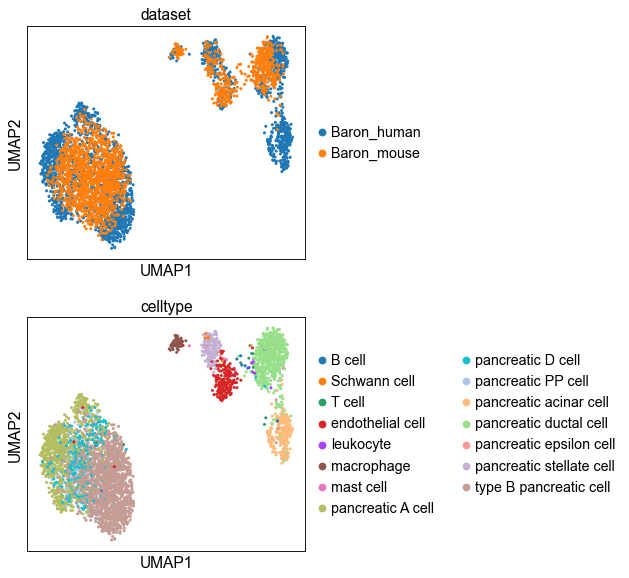

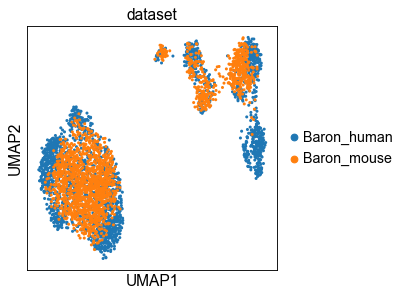

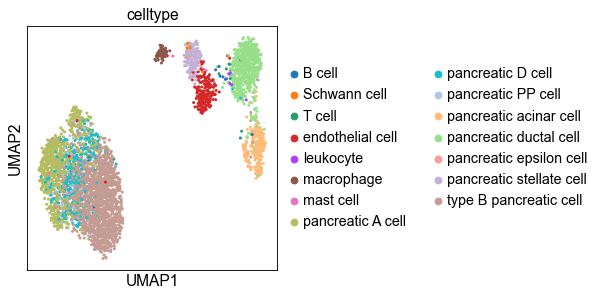

In [36]:
# In[]
'''======================= cell embeddings ======================='''
# from CAME_v0.utils.plot_pub import plot_pure_umap

sc.set_figure_params(dpi_save=200)

sc.pp.neighbors(adt, n_neighbors=15, metric='cosine', use_rep='X')
sc.tl.umap(adt)
sc.pl.umap(adt, color=['dataset', 'celltype'], ncols=1)
# setting UMAP to the original adata
obs_umap = adt.obsm['X_umap']
adata1.obsm['X_umap'] = obs_umap[obs_ids1]
adata2.obsm['X_umap'] = obs_umap[obs_ids2]

ftype = ['.svg', ''][1]
sc.pl.umap(adt, color='dataset', save=f'-dataset{ftype}')
sc.pl.umap(adt, color='celltype', save=f'-ctype{ftype}')

adt.write(resdir / 'adt_hidden_cell.h5ad')



In [43]:
adt.obs_names = adt.obs_names.astype(str)

In [44]:
# In[]
''' similaraties of cell-type embeddings
'''
dsn1, dsn2 = dsnames
adt.obs_names
adt1, adt2 = pp.bisplit_adata(adt, 'dataset', dsn1, reset_index_by='original_name')
avg_embed1 = pp.group_mean_adata(adt1, 'celltype')
avg_embed2 = pp.group_mean_adata(adt2, 'celltype')

from scipy.spatial.distance import cdist
dist = cdist(avg_embed1.values.T, avg_embed2.values.T, metric='cosine')
sim = pd.DataFrame(
        data=1 - dist,
        index=avg_embed1.columns, columns=avg_embed2.columns
        )           
ax = pl.heatmap(sim, order_col=True, order_row=True, figsize=(5, 4), 
                fp=resdir / 'celltype_embed_sim.png')
ax.figure.show()


Computing averages grouped by celltype
(13, 128)
Computing averages grouped by celltype
(12, 128)
Re-order the columns
Re-order the rows
figure has been saved into:
	../_temp/('Baron_human', 'Baron_mouse')-(07-11 23.54.18)/celltype_embed_sim.png


<ipython-input-44-c2a62aa0aa1f>:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  ax.figure.show()


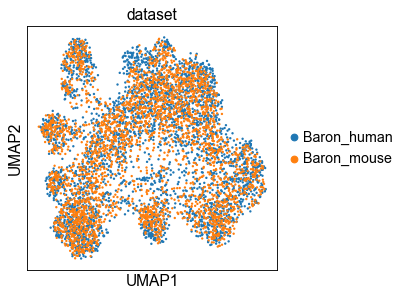

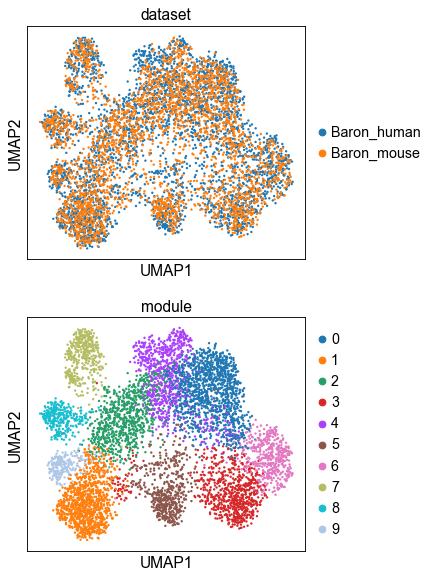

sorting links by weights


/Users/xingyan/.conda/envs/dgl/lib/python3.8/site-packages/anndata/_core/anndata.py:868: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    ['TCF25', 'CXCL2', 'CSRP3', 'AFAP1', 'IKZF3']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "obs")
/Users/xingyan/.conda/envs/dgl/lib/python3.8/site-packages/anndata/_core/anndata.py:868: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    ['Slc43a3', 'Ttr', 'D3Ertd751e', 'Gpr3', 'Gdf15']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "obs")


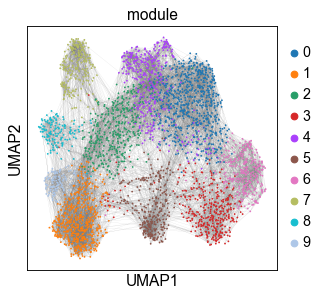

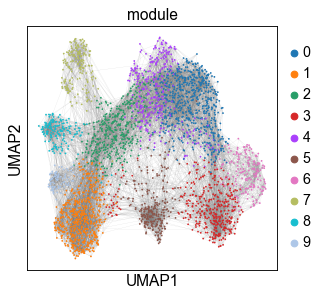

In [45]:
# In[]
'''===================== gene embeddings ====================='''
sc.set_figure_params(dpi_save=200)

sc.pp.neighbors(gadt, n_neighbors=15, metric='cosine', use_rep='X')
sc.tl.umap(gadt)
sc.pl.umap(gadt, color='dataset', )

''' joint gene module extraction '''
sc.tl.leiden(gadt, resolution=.8, key_added='module')
sc.pl.umap(gadt, color=['dataset', 'module'], ncols=1)

''' link-weights between homologous gene pairs '''
df_var_links = CAME.weight_linked_vars(
    gadt.X, dpair._vv_adj, names=dpair.get_vnode_names(),
    matric='cosine', index_names=dsnames,
)

# split
gadt.obs_names = gadt.obs_names.astype(str)
gadt1, gadt2 = pp.bisplit_adata(gadt, 'dataset', dsn1, reset_index_by='name')

color_by = 'module'
sc.pl.umap(gadt1, color=color_by, s=10, edges=True, edges_width=0.05,
           save=f'_{color_by}-{dsn1}')
sc.pl.umap(gadt2, color=color_by, s=10, edges=True, edges_width=0.05,
           save=f'_{color_by}-{dsn2}')



In [ ]:
# In[]
''' gene 3d map
'''



Computing averages grouped by cell_ontology_class
Calculating feature averages for 13 groups
['Schwann cell' 'T cell' 'endothelial cell' 'macrophage' 'mast cell'
 'pancreatic A cell' 'pancreatic D cell' 'pancreatic PP cell'
 'pancreatic acinar cell' 'pancreatic ductal cell'
 'pancreatic epsilon cell' 'pancreatic stellate cell'
 'type B pancreatic cell']
Computing averages grouped by cell_ontology_class
Calculating feature averages for 12 groups
['B cell' 'Schwann cell' 'T cell' 'endothelial cell' 'leukocyte'
 'macrophage' 'pancreatic A cell' 'pancreatic D cell' 'pancreatic PP cell'
 'pancreatic ductal cell' 'pancreatic stellate cell'
 'type B pancreatic cell']
adding columns to `adata.obs` (ignore_index=True):
Schwann cell, T cell, endothelial cell, macrophage, mast cell, pancreatic A cell, pancreatic D cell, pancreatic PP cell, pancreatic acinar cell, pancreatic ductal cell, pancreatic epsilon cell, pancreatic stellate cell, type B pancreatic cell, done!
adding columns to `adata.obs` 

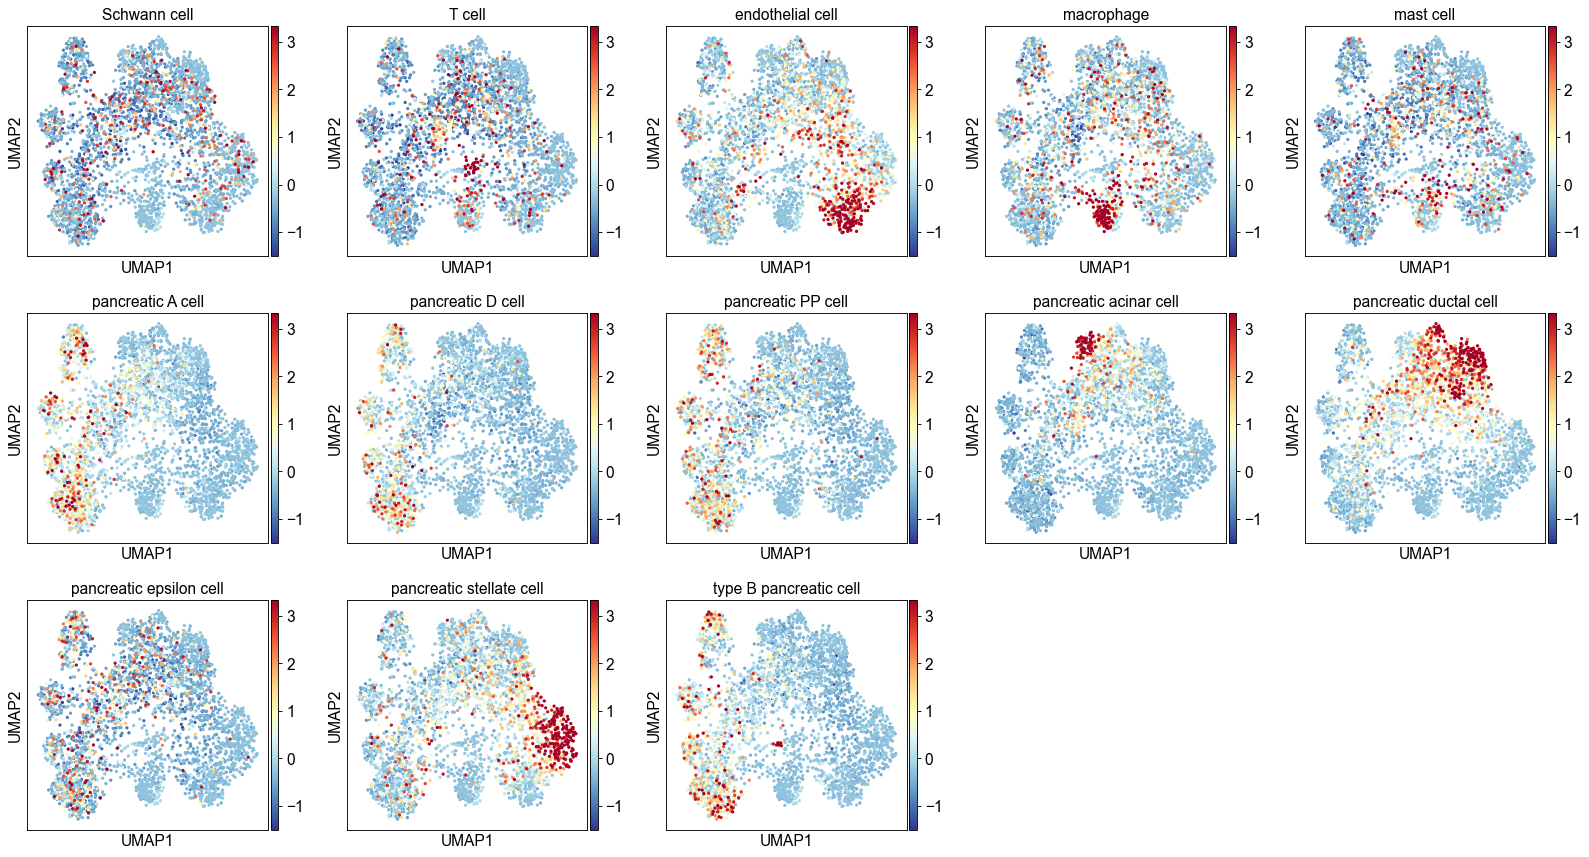

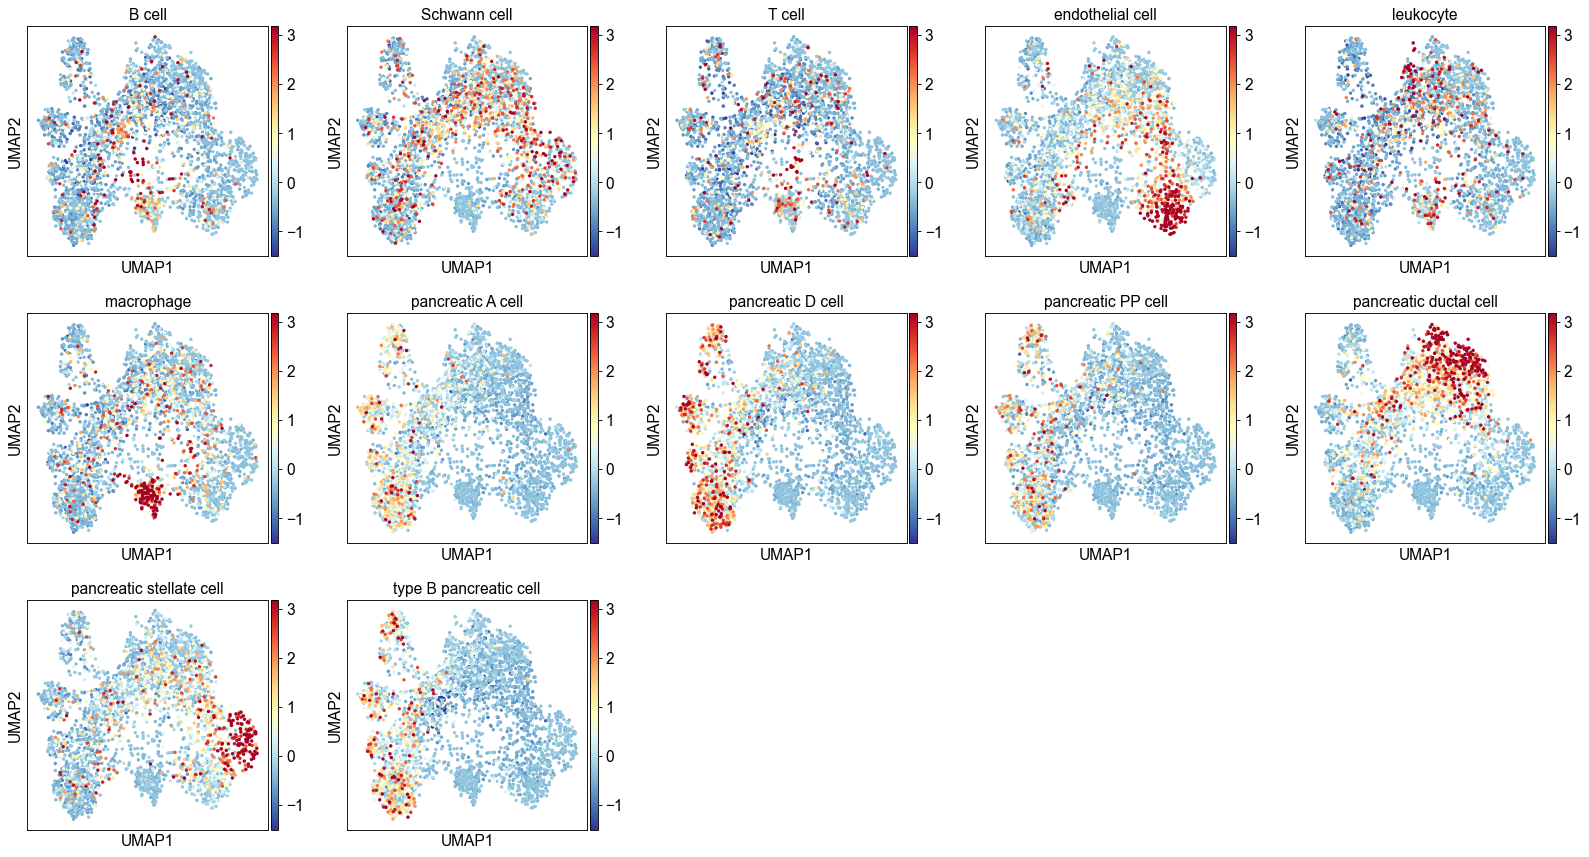

In [47]:
# In[]
''' ============ cell type gene-profiles on gene embeddings ============
'''
# averaged expressions
avg_expr1 = pp.group_mean_adata(adatas[0], groupby=key_class1,
                                features=dpair.vnode_names1, use_raw=True)
avg_expr2 = pp.group_mean_adata(adatas[1], groupby=key_class2,
                                features=dpair.vnode_names2, use_raw=True)
# adata_raw1.X.data

avg_expr_add1, avg_expr_add2 = list(map(
    lambda x: pp.zscore(x.T).T, (avg_expr1, avg_expr2)
))

# add annos
pp.add_obs_annos(gadt1, avg_expr_add1, ignore_index=True)
pp.add_obs_annos(gadt2, avg_expr_add2, ignore_index=True)

''' plot cell type gene-profiles (plot all the cell types) on UMAP '''
ctypes1 = avg_expr1.columns.tolist()
ctypes2 = avg_expr2.columns.tolist()
sc.set_figure_params(fontsize=14)
cmap_expr = 'RdYlBu_r'
vmax = None
vmin = - 1.5
plkwds = dict(color_map=cmap_expr, vmax=vmax, vmin=vmin, ncols=5, )
sc.pl.umap(gadt1, color=ctypes1,
           #           edges=True, size=50,
           save=f'_exprAvgs-{dsn1}-all.png', **plkwds)
sc.pl.umap(gadt2, color=ctypes2,
           #           edges=True, size=50,
           save=f'_exprAvgs-{dsn2}-all.png', **plkwds)

# gadt1.write(resdir / 'adt_hidden_gene1.h5ad')
# gadt2.write(resdir / 'adt_hidden_gene2.h5ad')


In [ ]:
# In[]
''' gene annotation on UMAP (top DEGs)
'''
fdir_gmap = resdir / 'gene_umap'
CAME.check_dirs(fdir_gmap)

adata1.obs[key_class1] = pd.Categorical(obs[key_class1][obs_ids1],
                                        categories=classes)
adata2.obs['predicted'] = pd.Categorical(obs['predicted'][obs_ids2],
                                         categories=classes)
pp.add_obs_annos(adata2, obs[classes].iloc[obs_ids2], ignore_index=True)

df_top1 = pp.compute_and_get_DEGs(adata1, key_class1, unique=False, )
df_top2 = pp.compute_and_get_DEGs(adata2, 'predicted',
                                  unique=False, )  # line 749
for _adt, sp, _df_top in zip([gadt1, gadt2],
                             (sp1, sp2),
                             (df_top1, df_top2),
                             ):
    for c in _df_top.columns[: 2]:
        text_ids = _df_top[c].head(10)

        nm = _adt.obs['dataset'][0]
        ftps = ['pdf', 'svg', 'png']
        ftp = ftps[1]
        if c not in _adt.obs.columns:
            continue
        ax = pl.umap_with_annotates(_adt, color=c, text_ids=text_ids,
                                    #                                      edges=True, size=30,
                                    title=f'{sp} {c}',
                                    index_col='name',
                                    fp=fdir_gmap / f'hexpr-{c}-{nm}.{ftp}',
                                    **plkwds)
        ax.figure



In [49]:
# In[]
''' =================== abstracted graph ====================  '''
norm_ov = ['max', 'zs', None][1]
cut_ov = 0.  # 5#(0.5, 2.5)
# norm_ov = 'zs'
# cut_ov = (0.5, 2.5)
ovby = ['expr', 'attn'][0]
groupby_var = 'module'
obs_labels1, obs_labels2 = adt.obs['celltype'][dpair.obs_ids1], \
                           adt.obs['celltype'][dpair.obs_ids2]
var_labels1, var_labels2 = gadt1.obs[groupby_var], gadt2.obs[groupby_var]

sp1, sp2 = 'human', 'mouse'
g = CAME.make_abstracted_graph(
    obs_labels1, obs_labels2,
    var_labels1, var_labels2,
    avg_expr1, avg_expr2,
    df_var_links,
    tags_obs=(f'{sp1} ', f'{sp2} '),
    tags_var=(f'{sp1} module ', f'{sp2} module '),
    cut_ov=cut_ov,
    norm_mtd_ov=norm_ov,
)

''' visualization '''
fp_abs = figdir / f'abstracted_graph-{groupby_var}-cut{cut_ov}-{norm_ov}-{ovby}.pdf'
ax = pl.plot_multipartite_graph(
    g, edge_scale=10,
    figsize=(9, 7.5), alpha=0.5, fp=fp_abs)  # nodelist=nodelist,

ax.figure
# unlabeled
ax = pl.plot_multipartite_graph(
    g, edge_scale=10, figsize=(9, 7.5), alpha=0.5,
    xscale=1.25,
    fp=figdir / f'abstracted_graph-nolabels.pdf',
    with_labels=False)  # nodelist=nodelist,



3421 3135
---> ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Edges with weights lower than 0 were cut out.
Edges with weights lower than 0 were cut out.
---> avg_vo1
                  Schwann cell    T cell  endothelial cell  macrophage  \
__temp_labels__                                                         
0                   -0.191889 -0.246011          0.344696    0.137301   
1                   -0.338496 -0.440526         -0.135832   -0.151983   
2                   -0.223087 -0.061279         -0.018686   -0.151418   
3                   -0.171332 -0.137073          1.925296    0.198827   
4                   -0.317960 -0.258952          0.122327    0.071435   
5                   -0.256456  0.532343         -0.236573    1.573409   
6                   -0.031281 -0.242848          0.339113   -0.076576   
7                   -0.362332 -0.448704         -0.183364   -0.070007   
8                   -0.404608 -0.487003          0.033638   -0.101811   
9                   -0.22

../CAME/utils/plot.py:879: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodedf['plt_color'] = nodedf['subset'].apply(
../CAME/utils/plot.py:879: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodedf['plt_color'] = nodedf['subset'].apply(
../CAME/utils/plot.py:879: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodedf['plt_color'] = nodedf['subset'].apply(
../CAME/utils/plot.py:879: SettingWithCopyWarning: 
A value is trying to be set on

### TF-target exploration

In [ ]:
''' TF-target exploration '''

human_tf = pd.read_csv(f'../resources/TF/fantomTFs-human.csv')['Symbol']
mouse_tf = pd.read_csv(f'../resources/TF/fantomTFs-mouse.csv')['Symbol']
TFdict = {'mouse': mouse_tf,
          'human': human_tf,
          }

# In[]

''' annotate TFs on gene UMAP '''
